# Final Project for Research Computing in Earth Science
## *Investigating Ocean Acidification in the Arctic* 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pooch
import ipywidgets as widgets
import matplotlib
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Data Import and Creation of Datasets

## CESM Historical Data

In [2]:
# structure : {base_url}{variables}{scenarios}
historical_base_url = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2/CESM2_{}_historical.nc#mode=bytes'
variables = ['Temperature','Salinity','pHT','pCO2']

historical_url_list = []
for variable in variables:
    historical_url_list.append(historical_base_url.format(variable)) 
    
data = []
for url in historical_url_list:
    data.append(xr.open_dataset(url))
        
cesm_historical = xr.merge(data)   

In [3]:
cesm_historical = cesm_historical.set_coords(['longitude', 'latitude'])
cesm_historical['longitude']= cesm_historical['longitude']-20.5
cesm_historical['time'] = pd.to_datetime(cesm_historical.time, format='%Y')

In [ ]:
cesm_historical

## CESM Emission Scenarios

[Index of /data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2]('https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2/')

In [4]:
# structure : {base_url}{variables}{scenarios}
cesm = {}
cesm_base_url = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2/CESM2_{}_{}.nc#mode=bytes'
scenarios = ['ssp126','ssp245','ssp370','ssp585'] #'historical',
variables = ['Temperature','Salinity','pHT','pCO2']

for scenario in scenarios:
    cesm_url_list = []
    for variable in variables:
        cesm_url_list.append(cesm_base_url.format(variable,scenario)) 
    
    data = []
    for url in cesm_url_list:
        data.append(xr.open_dataset(url))
        
    cesm[scenario] = xr.merge(data)   

In [ ]:
# cesm['ssp126']

In [ ]:
# type(cesm)

In [ ]:
# cesm

In [ ]:
# type(cesm['ssp126'])

### At this stage, have each scenario stored as Xarray dataset, with all emission scenarios combined into "cesm" dictionary

### To ease later analysis, will: 
- Use pandas to recognize time as dates 
    - Note that this puts years in year-month-day format, even though each variable is representing a whole decade
    - Will keep this mind for conclusions but make the change anyway, because enables easier selection during analysis
- Set latitude and longitude as additional coordinates
    - Note that longitude is given in 20.5 to 379.5 degrees, converted to 0 to 360 degree scale

In [5]:
for scenario in scenarios:
    cesm[scenario] = cesm[scenario].set_coords(['longitude', 'latitude'])
    cesm[scenario]['longitude']= cesm[scenario]['longitude']-20.5
    cesm[scenario]['time'] = pd.to_datetime(cesm[scenario].time, format='%Y')

## Sea Ice Extent

[Sea Ice Concentration, NOAA/NSIDC Climate Data Record V3, Arctic, 25km, Science Quality, 1978-2019, Monthly DEPRECATED]('https://polarwatch.noaa.gov/erddap/files/nsidcCDRiceSQnhmday/')

Will determine sea ice extent by sea ice concentration, defined where sea ice concentration is less than 15% in September of each year (as done in Krasting et al. 2022)

In [9]:
from erddapy import ERDDAP
import json
e = ERDDAP(
    server='https://polarwatch.noaa.gov/erddap',
    protocol='griddap')

### First get latitude and longitude grid for the Arctic (Northern Hemisphere)

In [10]:
e.dataset_id = 'nsidcCDRice_nh_grid' # https://polarwatch.noaa.gov/erddap/griddap/nsidcCDRice_nh_grid.html
e.griddap_initialize()
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}')
ds_latlon = e.to_xarray()
ds_latlon.load()

variables in this dataset:

['longitude', 'latitude']

constraints for this dataset:

{
 "ygrid>=": 5837500.0,
 "ygrid<=": -5337500.0,
 "ygrid_step": 1,
 "xgrid>=": -3837500.0,
 "xgrid<=": 3737500.0,
 "xgrid_step": 1
}


<xarray.Dataset>
Dimensions:    (ygrid: 448, xgrid: 304)
Coordinates:
  * ygrid      (ygrid) float32 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid      (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    longitude  (ygrid, xgrid) float64 168.3 168.1 168.0 ... -10.36 -10.18 -9.999
    latitude   (ygrid, xgrid) float64 31.1 31.2 31.3 31.39 ... 34.68 34.58 34.47
Attributes: (12/62)
    acknowledgement:                             This project was supported i...
    cdm_data_type:                               Grid
    contributor_name:                            Walt Meier, Ruth Duerr, Flor...
    contributor_role:                            PrincipalInvestigator,author...
    Conventions:                                 CF-1.6, COARDS, ACDD-1.3
    creator_email:                               nsidc@nsidc.org
    ...                                          ...
    source:                                       Satellite observations
    sourceUrl:                                   ftp://sidads.colorado.edu/pu...
    spatial_resolution:                          25km
    standard_name_vocabulary:                    CF Standard Name Table v29
    summary:                                     This ERDDAP data set provide...
    title:                                       Sea Ice Concentration Lat-Lo...

### Then get sea ice concentration on a monthly basis from 1978 to 2022

In [11]:
e.dataset_id = 'nsidcG02202v4nhmday' # https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.html
e.griddap_initialize()
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}')
e.variables = ['cdr_seaice_conc_monthly'] #  consider if need any other variables from list printed by line above
e.constraints = None
ds = e.to_xarray()
ds

variables in this dataset:

['cdr_seaice_conc_monthly', 'melt_onset_day_cdr_seaice_conc_monthly', 'nsidc_bt_seaice_conc_monthly', 'nsidc_nt_seaice_conc_monthly', 'qa_of_cdr_seaice_conc_monthly', 'stdev_of_cdr_seaice_conc_monthly']

constraints for this dataset:

{
 "time>=": "2022-05-01T00:00:00Z",
 "time<=": "2022-05-01T00:00:00Z",
 "time_step": 1,
 "ygrid>=": 5837500.0,
 "ygrid<=": -5337500.0,
 "ygrid_step": 1,
 "xgrid>=": -3837500.0,
 "xgrid<=": 3737500.0,
 "xgrid_step": 1
}


<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    comment:                                             none
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-05-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

In [12]:
ds_ice = xr.merge([ds, ds_latlon])
ds_ice

<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
    longitude                (ygrid, xgrid) float64 168.3 168.1 ... -9.999
    latitude                 (ygrid, xgrid) float64 31.1 31.2 ... 34.58 34.47
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    comment:                                             none
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-05-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

### To ease later analysis:
- Set coordinates as latitude and longitude
- (Note that time is already correctly identified as dates)

In [13]:
ds_ice = ds_ice.set_coords(['latitude', 'longitude'])
ds_ice

<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
    longitude                (ygrid, xgrid) float64 168.3 168.1 ... -9.999
    latitude                 (ygrid, xgrid) float64 31.1 31.2 ... 34.58 34.47
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    comment:                                             none
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-05-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

In [14]:
# ds_ice.latitude.min()

<xarray.DataArray 'latitude' ()>
array(31.10267175)

In [15]:
# ds_ice.latitude.max()

<xarray.DataArray 'latitude' ()>
array(89.836816)

# Characterization Figures

### Create Plots to Examine CESM Data

In [6]:
scenarios_min = cesm_historical.sel(time='1750-01-01').pCO2.min()
scenarios_max = cesm['ssp585'].sel(time='2050').pCO2.max()

date_options = cesm['ssp585'].time
date_labels = ['2020','2030','2040','2050','2060','2070','2080','2090','2100']

def merge(labels, values):
      
    merged_list = [(labels[i], values[i]) for i in range(0, len(labels))]
    return merged_list
      
merged_dates = merge(date_labels, date_options)

In [7]:
def create_comparison(Select_date):
    scenarios_min = cesm_historical.sel(time='1750-01-01').pCO2.min()
    scenarios_max = cesm['ssp585'].sel(time='2100').pCO2.max()

    fig, axes = plt.subplots(figsize=(12,15),nrows=3)
    ax0, ax1, ax2 = axes

    cesm_historical.sel(time='1750-01-01').pCO2.plot(ax=ax0,vmin=scenarios_min,vmax=scenarios_max,cmap='Spectral_r')
    ax0.set_title('Pre-Industrial Global pCO2')

    cesm['ssp126'].sel(time=Select_date,method='nearest').pCO2.plot(ax=ax1,vmin=scenarios_min,vmax=scenarios_max,cmap='Spectral_r')
    ax1.set_title('Global pCO2 under Low Emission Scenario')

    cesm['ssp585'].sel(time=Select_date,method='nearest').pCO2.plot(ax=ax2,vmin=scenarios_min,vmax=scenarios_max,cmap='Spectral_r')
    ax2.set_title('Global pCO2 under High Emission Scenario')

In [8]:
widgets.interact(create_comparison,Select_date=merged_dates)

interactive(children=(Dropdown(description='Select_date', options=(('2020', <xarray.DataArray 'time' ()>
array…

<function __main__.create_comparison(Select_date)>

### Arctic-Specific pCO2 Maps

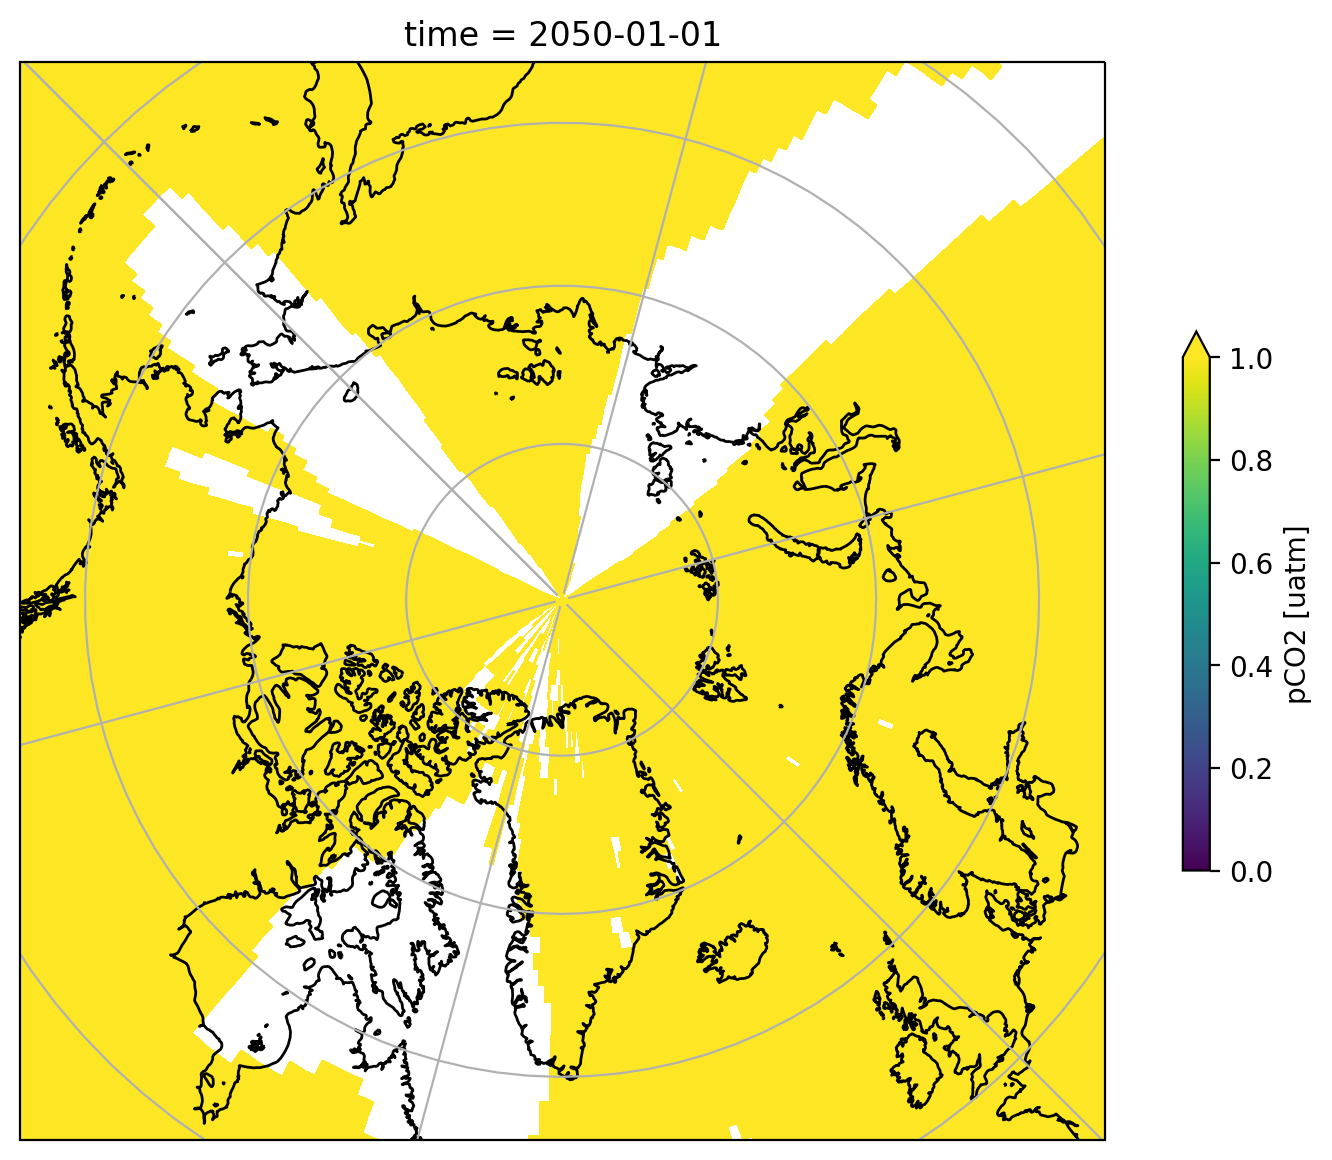

In [16]:
fig = plt.figure(figsize=(10,7))
proj_ant = ccrs.NorthPolarStereo(central_longitude=-45) #other is -45, to match need 135
ax = plt.axes(projection=proj_ant)
ax.set_extent([0, 360, 100, 56], crs=ccrs.PlateCarree()) #100, 56
ax.coastlines()
ax.gridlines()

cesm['ssp585'].sel(time='2050').pCO2.plot(vmin=0, vmax=1, cbar_kwargs={'shrink': 0.5},transform=ccrs.PlateCarree(central_longitude=180))

### Create Plots to Examine Sea Ice Data

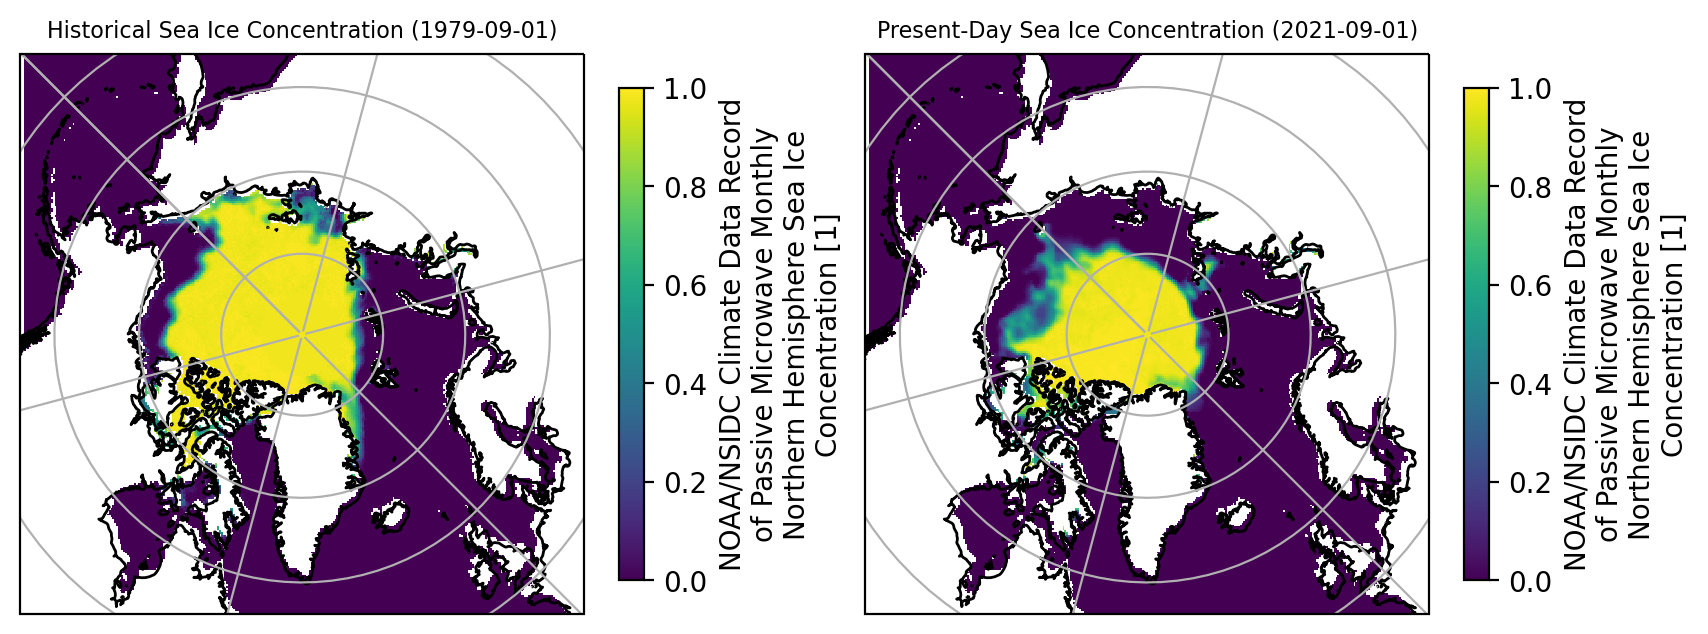

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(10,8),subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-45)})
#fig = plt.figure(figsize=(10,7))
#proj_ant = ccrs.NorthPolarStereo(central_longitude=-45)
#ax = plt.axes(projection=proj_ant)
ax0, ax1 = axes 
for ax in ax0, ax1:
    ax.set_extent([-180, 180, 100, 56], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    
ice_conc_hist = ds_ice.cdr_seaice_conc_monthly.sel(time='1979-09-01')
ice_conc_hist = ice_conc_hist.where(ice_conc_hist<=1)
ice_conc_hist.plot(ax=ax0,vmin=0, vmax=1, cbar_kwargs={'shrink': 0.4})
ax0.set_title('Historical Sea Ice Concentration (1979-09-01)')
ax0.title.set_size(8)

ice_conc_pres = ds_ice.cdr_seaice_conc_monthly.sel(time='2021-09-01') # did 10 to look at September, also try ds_ice.cdr_seaice_conc[ds_ice.cdr_seaice_conc.time=='2021-09-01']
ice_conc_pres = ice_conc_pres.where(ice_conc_pres<=1)
ice_conc_pres.plot(ax=ax1,vmin=0, vmax=1, cbar_kwargs={'shrink': 0.4}) 
ax1.set_title('Present-Day Sea Ice Concentration (2021-09-01)')
ax1.title.set_size(8)

Text(0.5, 1.0, 'Difference between Historical and Present Sea Ice Concentration')

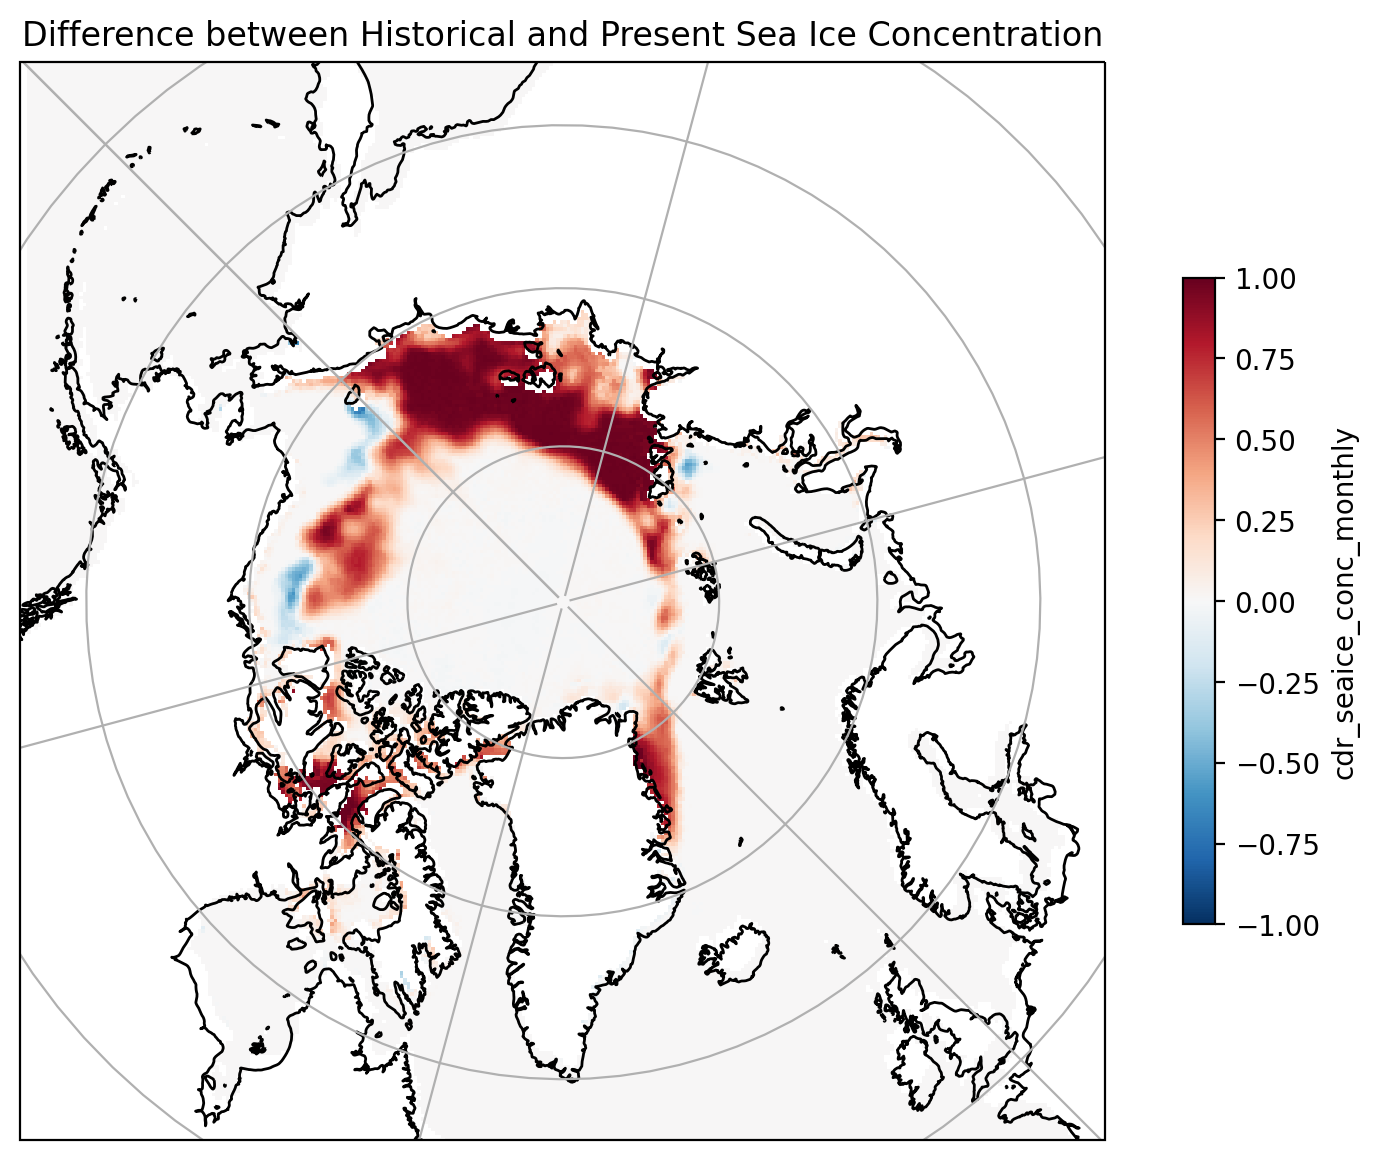

In [19]:
fig = plt.figure(figsize=(10,7))
proj_ant = ccrs.NorthPolarStereo(central_longitude=-45)
ax = plt.axes(projection=proj_ant)
ax.set_extent([-180, 180, 100, 56], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
ice_conc_diff = ice_conc_hist - ice_conc_pres
ice_conc_diff.plot(cbar_kwargs={'shrink': 0.6}) 
ax.set_title('Difference between Historical and Present Sea Ice Concentration')

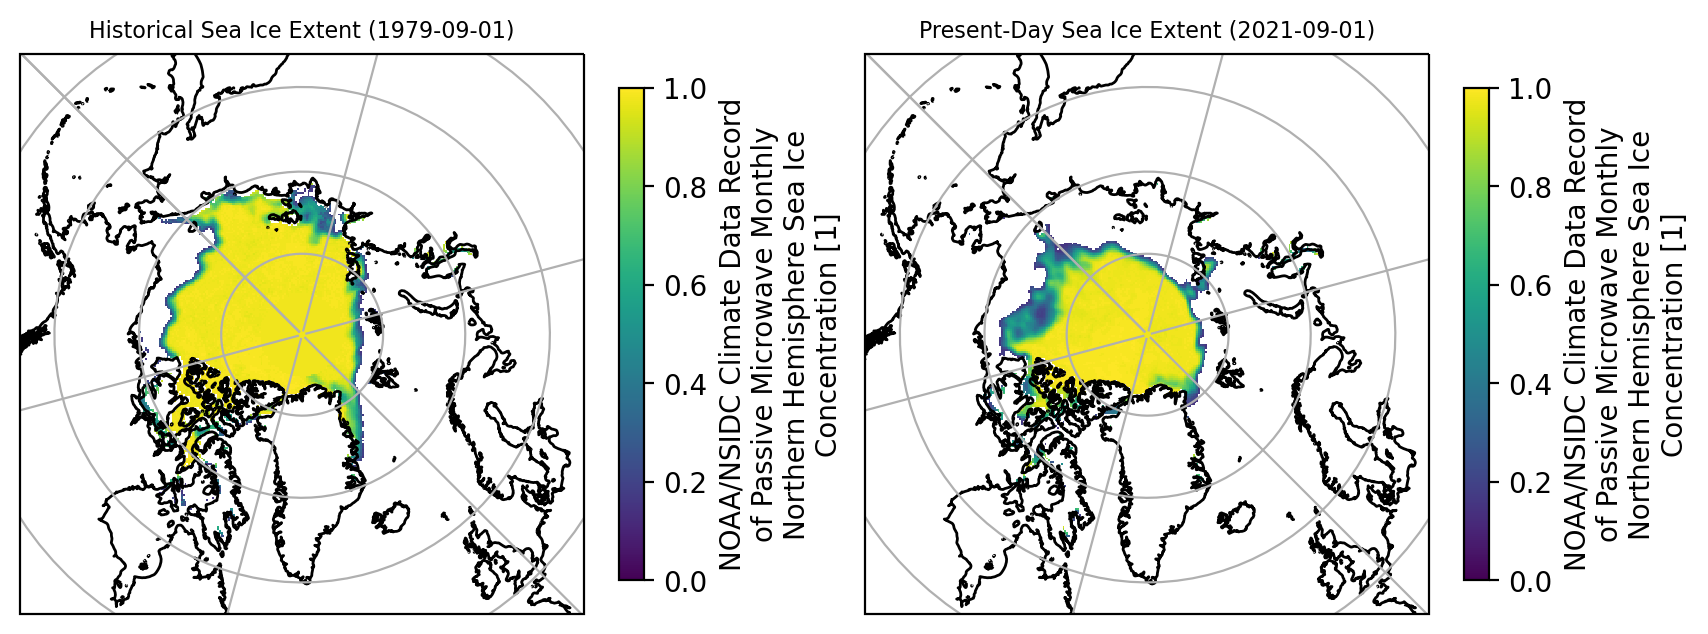

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10,8),subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-45)})
#fig = plt.figure(figsize=(10,7))
#proj_ant = ccrs.NorthPolarStereo(central_longitude=-45)
#ax = plt.axes(projection=proj_ant)
ax0, ax1 = axes 
for ax in ax0, ax1:
    ax.set_extent([-180, 180, 100, 56], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()

ice_extent_hist = ice_conc_hist.where(ice_conc_hist>=0.15)
ice_extent_hist.plot(ax=ax0,vmin=0, vmax=1, cbar_kwargs={'shrink': 0.4})
ax0.set_title('Historical Sea Ice Extent (1979-09-01)')
ax0.title.set_size(8)

ice_extent_pres = ice_conc_pres.where(ice_conc_pres>=0.15)
ice_extent_pres.plot(ax=ax1,vmin=0, vmax=1, cbar_kwargs={'shrink': 0.4}) 
ax1.set_title('Present-Day Sea Ice Extent (2021-09-01)')
ax1.title.set_size(8)

In [ ]:
# ice_extent_hist['longitude']= ice_extent_hist['longitude']+9.999 
# ice_extent_pres['longitude']= ice_extent_pres['longitude']+9.999 

# Analysis and Resulting Figures

## Calculate sea ice concentration anomaly

In [24]:
ice_monthly = ds_ice.cdr_seaice_conc_monthly.mean(dim=('ygrid', 'xgrid'))
by_month = ice_monthly.groupby(ice_monthly['time'].dt.month)

In [25]:
by_month.mean()

<xarray.DataArray 'cdr_seaice_conc_monthly' (month: 12)>
array([0.4958386 , 0.49751723, 0.4999588 , 0.48087987, 0.44659713,
       0.40427953, 0.36631212, 0.3080037 , 0.2982376 , 0.33913657,
       0.39418   , 0.4589454 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

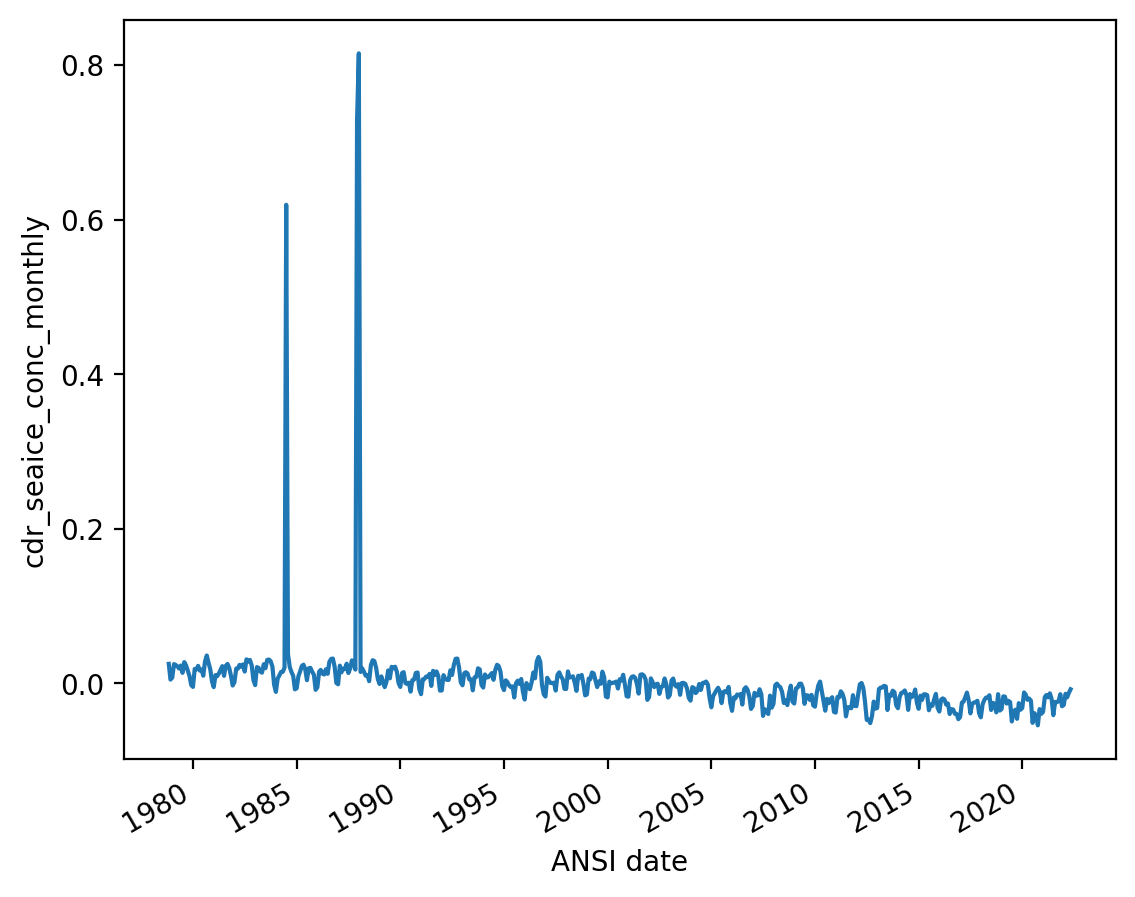

In [26]:
by_month = ice_monthly.groupby(ice_monthly['time'].dt.month) #note grouping conc values by month, not just datapoint counts
anomaly = by_month - by_month.mean() #fine for now but rolling may be better
anomaly.plot()
#anomaly.resample('A').mean().plot(marker='.');
ax.set_title('Monthly Anomaly of Sea Ice Concentration'); 

In [27]:
# Feels wrong though: shouldn't calculate anomaly based on only previous years? Try rolling approach? Or will this be sufficient for project?

In [ ]:
by_month.first?

In [ ]:
by_month.first()

In [ ]:
by_month.last()

In [ ]:
by_month.mean()

In [ ]:
by_month.month[9]

# Conclusions